In [1]:
%autosave 0

Autosave disabled


# Ejercicio 1
***
***

In [2]:
import sys
import os
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
HDFS_NAMENODE_HOST = os.environ.get("HDFS_NAMENODE_HOST")
HDFS_NAMENODE_RPC_PORT = os.environ.get("HDFS_NAMENODE_RPC_PORT")
SPARK_MASTER_HOST = os.environ.get("SPARK_MASTER_HOST")
SPARK_MASTER_PORT = os.environ.get("SPARK_MASTER_PORT")
SPARK_LOGS_HDFS_PATH = os.environ.get("SPARK_LOGS_HDFS_PATH")

In [4]:
sys.version

'3.6.15 (default, Nov 24 2025, 15:08:05) \n[GCC 9.4.0]'

In [5]:
pyspark.__version__

'2.3.0'

In [6]:
spark = SparkSession.builder  \
    .appName("GrandataEj1")  \
    .config("spark.executor.memory", "2g")  \
    .config("spark.eventLog.enabled", "true")  \
    .config("spark.eventLog.dir",  SPARK_LOGS_HDFS_PATH)   \
    .master(f"spark://{SPARK_MASTER_HOST}:{SPARK_MASTER_PORT}")  \
    .getOrCreate()

In [7]:
spark

In [8]:
REGIONS = [i for i in range(1,10)]
LOW_SMS_RATE_REGIONS = [i for i in range(1,6)]
LOW_SMS_RATE = 1.5
HIGH_SMS_RATE = 2

***
***
## Analisis Exploratorio
***

In [9]:
# Leo datasets
path = "file:///opt/workspace/exercises/datasets/events.csv.gz"
df_events = spark.read.csv(path=path, header=True)

path = "file:///opt/workspace/exercises/datasets/free_sms_destinations.csv.gz"
df_free = spark.read.csv(path=path, header=True)

In [10]:
df_events.limit(5).show()
df_events.printSchema()
print(f"Shape: {df_events.count()}, {len(df_events.columns)}")

+----+-----+-------+---+--------+------+---------+--------------+
|hour|calls|seconds|sms|    date|region|id_source|id_destination|
+----+-----+-------+---+--------+------+---------+--------------+
|  11|    1|     24|  0|20211001|     5|      BF3|           374|
|   1|    1|     51|  0|20211001|     4|      9F5|           374|
|  11|    1|      3|  0|20211001|     6|      025|           374|
|  10|    1|     36|  0|20211001|     5|      FB6|           D52|
|  23|    4|    137|  0|20211001|     8|      4BB|           861|
+----+-----+-------+---+--------+------+---------+--------------+

root
 |-- hour: string (nullable = true)
 |-- calls: string (nullable = true)
 |-- seconds: string (nullable = true)
 |-- sms: string (nullable = true)
 |-- date: string (nullable = true)
 |-- region: string (nullable = true)
 |-- id_source: string (nullable = true)
 |-- id_destination: string (nullable = true)

Shape: 1000000, 8


In [11]:
# Exploracion de Nulos
df_events.select([F.count(F.when(F.isnull(col), col)).alias(col) for col in df_events.columns]).show()

# Exploracion de NaNs
df_events.select([F.count(F.when(F.isnan(col), col)).alias(col) for col in df_events.columns]).show()

+----+-----+-------+---+----+------+---------+--------------+
|hour|calls|seconds|sms|date|region|id_source|id_destination|
+----+-----+-------+---+----+------+---------+--------------+
|   0|    0|      0|  0|   0|     0|       18|            15|
+----+-----+-------+---+----+------+---------+--------------+

+----+-----+-------+---+----+------+---------+--------------+
|hour|calls|seconds|sms|date|region|id_source|id_destination|
+----+-----+-------+---+----+------+---------+--------------+
|   0|    0|      0|  0|   0|     0|        0|             0|
+----+-----+-------+---+----+------+---------+--------------+



In [12]:
# Verifico si hay registros fuera de las 9 regiones para las que tengo tarifa
df_events.filter(~F.col("region").isin(REGIONS)).count()

0

***

In [13]:
df_free.limit(5).show()
df_free.printSchema()
print(f"Shape: {df_free.count()}, {len(df_free.columns)}")

+---+
| id|
+---+
|374|
|D52|
|861|
|5B0|
|4CA|
+---+

root
 |-- id: string (nullable = true)

Shape: 200, 1


In [14]:
# Exploracion de Nulls
df_free.select([F.count(F.when(F.isnull(col), col)).alias(col) for col in df_free.columns]).show()

# Exploracion de NaNs
df_free.select([F.count(F.when(F.isnan(col), col)).alias(col) for col in df_free.columns]).show()

+---+
| id|
+---+
|  0|
+---+

+---+
| id|
+---+
|  0|
+---+



***
***
## Inciso 1
**_Calcular el monto total que facturará el proveedor del servicio por envíos de sms._**
***

**Descartamos registros con id_source o id_destination nulo.**

**Descartamos registros sin SMS para filtrar lo más posible los datos antes del join.**

**Hacemos un join "left_anti" (notar que es análogo a un "left outer" seguido de un a selección de las columnas con id Null).**

**Agregamos columna con la tarifa de SMS según región (notar que como sé que no hay registros con regiones fuera de las tarifadas, puedo hacer una evaluación binaria).**

In [15]:
df_events = df_events.dropna(subset=["id_source", "id_destination"])

df_sms = df_events.filter(F.col("sms") != 0) \
                  .join(df_free, on=[df_events.id_destination == df_free.id], how='left_anti') \
                  .withColumn("rate_sms", F.when(df_events.region.isin(LOW_SMS_RATE_REGIONS), LOW_SMS_RATE) \
                              .otherwise(HIGH_SMS_RATE))

**Agregamos columna con facturación total por SMS por registro y agrego para obtener el resultado buscado...**

In [16]:
df_sms = df_sms.withColumn("sms_hour_billing", df_sms.rate_sms*df_sms.sms)
df_sms.select(F.sum(df_sms.sms_hour_billing).alias("sms_total_billing")).show()

+-----------------+
|sms_total_billing|
+-----------------+
|         391367.0|
+-----------------+



***
***
## Inciso 2
**_Generar un dataset que contenga los ID de los 100 usuarios con mayor facturación por envío de sms y el monto total a facturar a cada uno. Además del ID, incluir el ID hasheado mediante el algoritmo MD5. Escribir el dataset en formato parquet con compresión gzip._**
***

**Agregamos facturación horaria por SMS agrupango por ID de usuario de origen.**

**Nos quedamos con los 100 de mayor facturación y agrego una columna hasheando el ID.**

In [17]:
df_unload = df_sms.groupBy("id_source").agg(F.sum("sms_hour_billing").alias("user_sms_total_billing"))\
                                       .orderBy(F.col("user_sms_total_billing").desc()).limit(100) \
                                       .withColumn("id_source_md5", F.md5(df_sms.id_source))


df_unload.limit(5).show(truncate=False)
path = f"hdfs://{HDFS_NAMENODE_HOST}:{HDFS_NAMENODE_RPC_PORT}/data/top100billings.parquet"
df_unload.coalesce(1).write.parquet(path=path, compression="gzip")

+---------+----------------------+--------------------------------+
|id_source|user_sms_total_billing|id_source_md5                   |
+---------+----------------------+--------------------------------+
|4D3      |23403.0               |911914c7729eedbdf5b0f03159f451a9|
|76D      |13664.0               |bd180b7811395cbce5076b52a78ca50d|
|07E      |4226.0                |14a0660ae2f5d186882df86c2972fa93|
|541      |2526.0                |16c222aa19898e5058938167c8ab6c57|
|C25      |2019.0                |0bfa0b57d99985aa138ce05055a3c5db|
+---------+----------------------+--------------------------------+



**Verifico escritura...**

In [18]:
df_read = spark.read.parquet(path)
df_read.limit(5).show()
df_read.count()
# O desde la namenode UI Utilities > Browse the file system
# O desde una terminal del host con..
# `docker exec namenode bash -lc 'hdfs dfs -ls /data/top100billings.parquet'`

+---------+----------------------+--------------------+
|id_source|user_sms_total_billing|       id_source_md5|
+---------+----------------------+--------------------+
|      4D3|               23403.0|911914c7729eedbdf...|
|      76D|               13664.0|bd180b7811395cbce...|
|      07E|                4226.0|14a0660ae2f5d1868...|
|      541|                2526.0|16c222aa19898e505...|
|      C25|                2019.0|0bfa0b57d99985aa1...|
+---------+----------------------+--------------------+



100

***
***
## Inciso 3
**_Graficar un histograma de cantidad de llamadas que se realizan por hora del día._**
***

In [19]:
plt.style.use('seaborn-deep')

**Hacemos el reduce de los datos en spark para mandar small data a las funciones de graficado...**

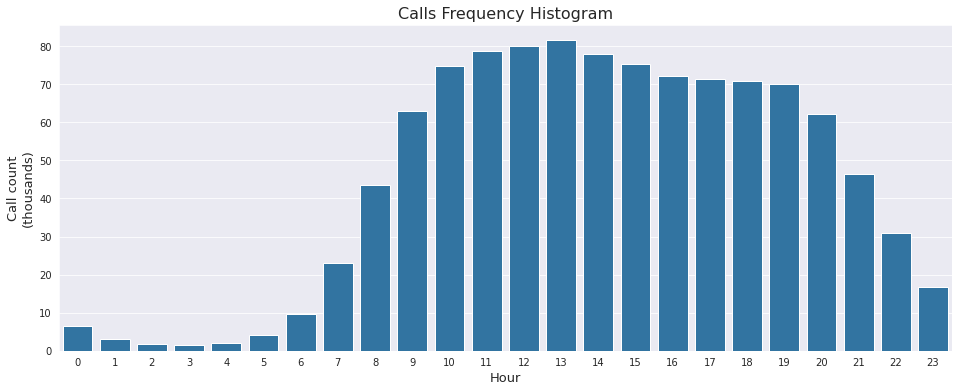

In [20]:
df_hist = df_events.groupBy("hour").agg(F.sum("calls").alias("hour_total_calls")) \
                   .withColumn("hour", F.col("hour").cast("integer")) \
                   .orderBy(F.col("hour"))

hours, calls = [], []
for row in df_hist.collect():
    hours.append(row.hour)
    calls.append(row.hour_total_calls/1000)
    
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(1,1,figsize=(16,6))
    sns.barplot(x=hours, y=calls, color="tab:blue", ci=None, ax=ax)
    ax.set_xlabel("Hour", fontsize=13)
    ax.set_ylabel("Call count\n(thousands)", fontsize=13)
    ax.set_title("Calls Frequency Histogram", fontsize=16)
    #fig.savefig("histogram1.png")

**Como bonus track generamos otro histograma discriminando por tarifa...**

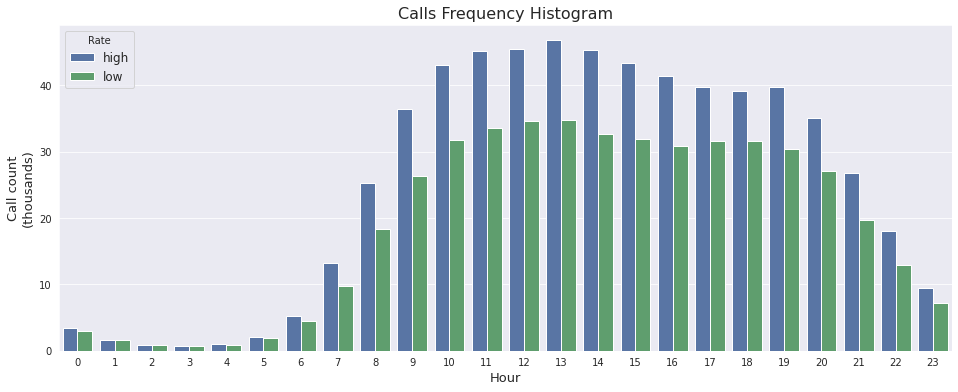

In [21]:
df_hist = df_events.withColumn("rate_sms", F.when(df_events.region.isin(LOW_SMS_RATE_REGIONS), "low").otherwise("high")) \
                   .groupBy(["hour", "rate_sms"]).agg(F.sum("calls").alias("hour_total_calls")) \
                   .withColumn("hour", F.col("hour").cast("integer")) \
                   .orderBy(F.col("hour"))

hours, calls, rate = [], [], []
for row in df_hist.collect():
    hours.append(row.hour)
    calls.append(row.hour_total_calls/1000)
    rate.append(row.rate_sms)
    
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(1,1,figsize=(16,6))
    sns.barplot(x=hours, y=calls, hue=rate, ci=None, ax=ax)
    ax.set_xlabel("Hour", fontsize=13)
    ax.set_ylabel("Call count\n(thousands)", fontsize=13)
    ax.set_title("Calls Frequency Histogram", fontsize=16)
    ax.legend(fontsize=12, title="Rate", loc=2)
    #fig.savefig("histogram2.png")

In [22]:
spark.stop()

***
***